## Imports

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer ## for handling the missing values
import seaborn as sns ## for data visualization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso,SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Get CSV File 

In [172]:
filepath = '../data/California_Houses.csv'
df = pd.read_csv(filepath)

### Print 1st 5 Rows using head

In [173]:
print(df.columns.tolist())
print(df.head())
print(df.shape)

['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms', 'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         5

### Before Training the model, make sure there are no missing values in your dataset

In [174]:
print(df.isnull().sum())
## All values were zero meaning there are no null values in this dataset

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64


### Separate Features and Target Value

Mean House Value:  206855.81690891474


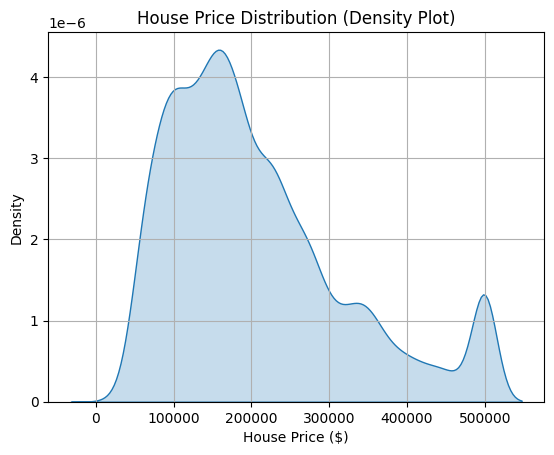

In [175]:
X= df.drop("Median_House_Value",axis=1)
# drop the target column(median house value) and leaving only the independent features

y=df["Median_House_Value"]
# y is the target value

print("Mean House Value: ",y.mean())

sns.kdeplot(data=df,x="Median_House_Value",fill=True)

plt.xlabel("House Price ($)")
plt.ylabel("Density")
plt.title("House Price Distribution (Density Plot)")
plt.grid(True)
plt.show()

Notice that there are some Outliers might need to exlude them to improve the accuracy

# Data Splitting

In [176]:
X_train, X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.30,random_state=42)

# train_test_split is used to split dataset into a training set and a temporary one
# to use again to split it to validation and test sets
X_validation,X_test,y_validation,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

print(X_train.shape)
print(y_train.shape) ## i want it to be (m,1)

(14448, 13)
(14448,)


In [177]:
##Reshape
y_train = np.array(y_train).reshape(-1, 1)
y_validation=np.array(y_validation).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1) # -1 means take the number of rows as it's 

print(y_train.shape)

(14448, 1)


## Scaling the data


In [178]:
# Scaling training
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

## Manual Linear Regression Implementation

In [179]:
def predict(X, w,b=None):
    # Compute predictions
    if b is None:
        X_b = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X_b, w) # working with y=X.w where X is design matrix
    else:
        return np.dot(X, w) + b
    

### Functions to Compute MAE , MSE

In [180]:
def compute_mae_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MAE (Mean Absolute Error)
    mae_cost = (1 / m) * np.sum(np.abs(y_pred - y))
    return mae_cost

def compute_mse_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MSE (Mean Square Error)
    mse_cost=(1 / (2*m) * np.sum((y_pred - y)** 2))
    return mse_cost

### Find Optimum Weights using Direct Solution

In [181]:
def normal_equation(X,y):
    X_b = np.hstack((np.ones((X.shape[0], 1)), X))  # (m, n+1)
    # Compute weights (w = (XᵀX)⁻¹Xᵀy)
    w = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return w

### Ridge (L2) Implementation

In [182]:
def compute_ridge_cost(X,y,w,b,lambda_ridge):
    ## should return total cost (MSE + L2 Penalty)
    m=X.shape[0]
    
    mse_cost=compute_mse_cost(X,y,w,b)
    l2_penalty=(lambda_ridge / (2*m)) * np.sum(w **2)
    total_cost = mse_cost + l2_penalty
    
    return total_cost

def compute_ridge_gradient(X,y,w,b,lambda_ridge):
    ## should return dw , db
    m=X.shape[0]
    
    y_pred=predict(X,w,b)
    dw=(1/m) * np.dot(X.T,(y_pred-y)) + (lambda_ridge/m) * w
    db=(1/m) * np.sum(y_pred-y)
    
    return dw,db

### Functions to Compute Gradient Descent

In [183]:
def compute_gradient(X,y,w,b):
    m=X.shape[0]
    y_pred=predict(X,w,b)
    dw = (1 / m) * np.dot(X.T, (y_pred - y))   # (n, 1)
    db = (1 / m) * np.sum(y_pred - y)         
    return dw, db
    

def gradient_descent(X,y,w,b,alpha,num_iterations,ridge=False):
    #update weights to minimize the cost
    mse_cost_history=[]
    
    for i in range(num_iterations):
        if(ridge):
            dw,db=compute_ridge_gradient(X,y,w,b,alpha)
        else:
            dw,db=compute_gradient(X,y,w,b)
        w = w - alpha * dw
        b = b - alpha * db
        mae_cost =compute_mae_cost(X,y,w,b)
        mse_cost =compute_mse_cost(X,y,w,b)
        mse_cost_history.append(mse_cost)
    
        # if i % 100 == 0:
        #     print(f"Iteration {i}, MSE Cost: {mse_cost:.4f},MAE Cost: {mae_cost:.4f}")
    return w,b,mse_cost_history

# Linear Regression Model Manually

In [184]:
def train_model(X,y,alpha,num_iterations):
    m,n=X.shape
    w=np.zeros((n,1))
    b=0
    w,b,cost_history=gradient_descent(X,y,w,b,alpha,num_iterations,ridge=False)
    return w,b,cost_history

def evaluate_model(X_test,y_test,w,b=None):
    #to compute MSE, MAE ON Test set after training
    y_pred=predict(X_test,w,b)
    mse=np.mean((y_test-y_pred)**2)
    mae=np.mean(np.abs(y_test-y_pred))
    return mse,mae

def train_ridge_model(X,y,alpha,lambda_ridge,num_iterations):
    m,n=X.shape
    w=np.zeros((n,1))
    b=0
    
    w,b,cost_history=gradient_descent(X,y,w,b,alpha,num_iterations,ridge=True)
    return w,b,cost_history


### Manual Linear Regression using Direct Solution to find Optimum weights

In [185]:
w_normal=normal_equation(X_train_scaled,y_train)

# Predict
y_pred_train=predict(X_train_scaled,w_normal)
y_pred_val=predict(X_validation_scaled,w_normal)
y_pred_test=predict(X_test_scaled,w_normal)

mse_train,mae_train=evaluate_model(X_train_scaled,y_train,w_normal)
mse_val,mae_val=evaluate_model(X_validation_scaled,y_validation,w_normal)
mse_test,mae_test=evaluate_model(X_test_scaled,y_test,w_normal)

print("Linear Regression (Manual Implementation) Performance:")
print(f"Train MSE: {mse_train:.2f},  MAE: {mae_train:.2f}")
print(f"Validation MSE: {mse_val:.2f},  MAE: {mae_val:.2f}")
print(f"Test MSE: {mse_test:.2f},  MAE: {mae_test:.2f}")

Linear Regression (Manual Implementation) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


### Manual Linear Regression using Gradient Descent to find Optimum weights

In [186]:
alpha=0.2
num_iterations=10000

# Train
w,b,cost_history=train_model(X_train_scaled,y_train,alpha,num_iterations)

### Evaluate Manual Linear Regression
mse_train,mae_train=evaluate_model(X_train_scaled,y_train,w,b)
mse_val,mae_val=evaluate_model(X_validation_scaled,y_validation,w,b)
mse_test,mae_test=evaluate_model(X_test_scaled,y_test,w,b)

print("Linear Regression (Manual Implementation) Performance:")
print(f"Train MSE: {mse_train:.2f},  MAE: {mae_train:.2f}")
print(f"Validation MSE: {mse_val:.2f},  MAE: {mae_val:.2f}")
print(f"Test MSE: {mse_test:.2f},  MAE: {mae_test:.2f}")

Linear Regression (Manual Implementation) Performance:
Train MSE: 4730361972.26,  MAE: 49927.89
Validation MSE: 4907210127.71,  MAE: 50790.86
Test MSE: 4400806185.90,  MAE: 48782.53


In [187]:
learning_rate=0.1
num_iterations=10000
lambda_values=[0.001,0.01,0.1,1,10,100]

manual_ridge_res_mse=[]
manual_ridge_res_mae=[]

for lambda_ridge in lambda_values:
    print(f"Training with Lambda={lambda_ridge}")
    
    w_ridge, b_ridge, cost_history = train_ridge_model(
    X_train_scaled, y_train, 
    alpha=learning_rate, 
    lambda_ridge=lambda_ridge,
    num_iterations=num_iterations)
    
    # Evaluate
    train_mse, train_mae = evaluate_model(X_train_scaled, y_train, w_ridge, b_ridge)
    val_mse, val_mae = evaluate_model(X_validation_scaled, y_validation, w_ridge, b_ridge)
    test_mse, test_mae = evaluate_model(X_test_scaled, y_test, w_ridge, b_ridge)
    
    manual_ridge_res_mse.append(val_mse)
    manual_ridge_res_mae.append(val_mae)


Training with Lambda=0.001
Training with Lambda=0.01
Training with Lambda=0.1
Training with Lambda=1
Training with Lambda=10
Training with Lambda=100


In [188]:
# Find the best alpha for Ridge Manual
best_ridge_idx = np.argmin(manual_ridge_res_mse)
best_ridge_alpha = lambda_values[best_ridge_idx]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Ridge Validation MSE: {manual_ridge_res_mse[best_ridge_idx]:.2f}")
print(f"Best Ridge Validation MAE: {manual_ridge_res_mae[best_ridge_idx]:.2f}")

Best Ridge Alpha: 0.001
Best Ridge Validation MSE: 4907553841.47
Best Ridge Validation MAE: 50797.79


### Linear Regression Model using Direct Solution

In [189]:
#  Train the Linear Regression model
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_train_scaled, y_train)


LinearRegression()

# Predictions

In [190]:
#  Predictions
y_pred_train_lin_sk = lin_reg_sk.predict(X_train_scaled)
y_pred_val_lin_sk   = lin_reg_sk.predict(X_validation_scaled)
y_pred_test_lin_sk  = lin_reg_sk.predict(X_test_scaled)

#  Compute mse - mae
mse_train_lin_sk = mean_squared_error(y_train, y_pred_train_lin_sk)
mae_train_lin_sk = mean_absolute_error(y_train, y_pred_train_lin_sk)

mse_val_lin_sk = mean_squared_error(y_validation, y_pred_val_lin_sk)
mae_val_lin_sk = mean_absolute_error(y_validation, y_pred_val_lin_sk)

mse_test_lin_sk = mean_squared_error(y_test, y_pred_test_lin_sk)
mae_test_lin_sk = mean_absolute_error(y_test, y_pred_test_lin_sk)

#  Display results of linear regression - STANDARD
print("Linear Regression (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_lin_sk:.2f},  MAE: {mae_train_lin_sk:.2f}")
print(f"Validation MSE: {mse_val_lin_sk:.2f},  MAE: {mae_val_lin_sk:.2f}")
print(f"Test MSE: {mse_test_lin_sk:.2f},  MAE: {mae_test_lin_sk:.2f}")

Linear Regression (Scikit-Learn) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


### Linear Regression Model using Stochastic Gradient Descent

In [191]:
sgd_reg = SGDRegressor(max_iter=2000, tol=1e-3, eta0=0.001, learning_rate='constant', random_state=42)

# Train on scaled training data
sgd_reg.fit(X_train_scaled, y_train.ravel())

# Predictions
y_pred_train_sgd = sgd_reg.predict(X_train_scaled)
y_pred_val_sgd   = sgd_reg.predict(X_validation_scaled)
y_pred_test_sgd  = sgd_reg.predict(X_test_scaled)

In [192]:
mse_train_sgd = mean_squared_error(y_train, y_pred_train_sgd)
mae_train_sgd = mean_absolute_error(y_train, y_pred_train_sgd)

mse_val_sgd = mean_squared_error(y_validation, y_pred_val_sgd)
mae_val_sgd = mean_absolute_error(y_validation, y_pred_val_sgd)

mse_test_sgd = mean_squared_error(y_test, y_pred_test_sgd)
mae_test_sgd = mean_absolute_error(y_test, y_pred_test_sgd)

# Display results
print("\nSGD Regressor (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_sgd:.2f},  MAE: {mae_train_sgd:.2f}")
print(f"Validation MSE: {mse_val_sgd:.2f},  MAE: {mae_val_sgd:.2f}")
print(f"Test MSE: {mse_test_sgd:.2f},  MAE: {mae_test_sgd:.2f}")


SGD Regressor (Scikit-Learn) Performance:
Train MSE: 4791585159.62,  MAE: 49832.61
Validation MSE: 5015284977.14,  MAE: 50884.71
Test MSE: 4455736305.29,  MAE: 48738.22


### Comparing the Performance of Sickit-Learn and Manual Implementation

#### Linear Regression (Scikit-Learn) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

#### Linear Regression (Manual Implementation) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

Results are quite close

# Ridge Regression 

In [193]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_mse = []
ridge_mae = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_validation_scaled)
    
    ridge_mse.append(mean_squared_error(y_validation, y_pred_val))
    ridge_mae.append(mean_absolute_error(y_validation, y_pred_val))


In [194]:
# Find the best alpha for Ridge
best_ridge_idx = np.argmin(ridge_mse)
best_ridge_alpha = alphas[best_ridge_idx]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Ridge Validation MSE: {ridge_mse[best_ridge_idx]:.2f}")
print(f"Best Ridge Validation MAE: {ridge_mae[best_ridge_idx]:.2f}")

Best Ridge Alpha: 0.001
Best Ridge Validation MSE: 4907212034.98
Best Ridge Validation MAE: 50790.06


### Plotting mean squared error


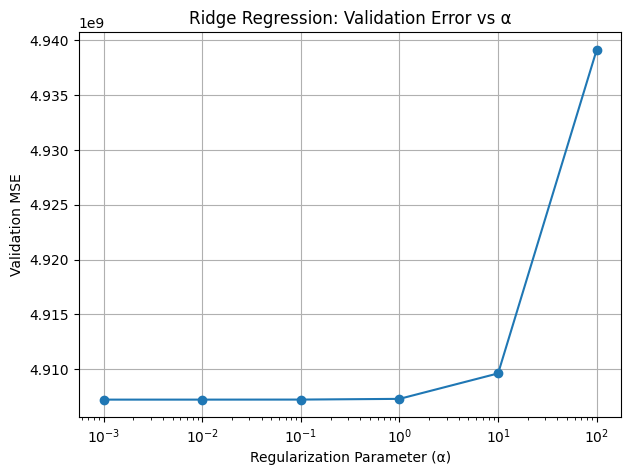

In [195]:

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, ridge_mse, marker='o')
plt.xscale('log')
plt.title("Ridge Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()

In [196]:
best_ridge_idx = np.argmin(ridge_mse)
best_ridge_alpha = alphas[best_ridge_idx]
print(f"Best Ridge Alpha: {best_ridge_alpha}")
print(f"Best Ridge Validation MSE: {ridge_mse[best_ridge_idx]:.2f}")
print(f"Best Ridge Validation MAE: {ridge_mae[best_ridge_idx]:.2f}")

Best Ridge Alpha: 0.001
Best Ridge Validation MSE: 4907212034.98
Best Ridge Validation MAE: 50790.06


In [197]:
best_ridge  = Ridge(alpha=best_ridge_alpha)
best_ridge .fit(X_train_scaled, y_train.ravel())

#Analyzing test set
ridge_test_pred = best_ridge.predict(X_test_scaled)

ridge_test_mse  = mean_squared_error(y_test, ridge_test_pred)
ridge_test_mae  = mean_absolute_error(y_test, ridge_test_pred)
print(f"Test MSE: {ridge_test_mse:.2f}, MAE: {ridge_test_mae:.2f}")


Test MSE: 4400952696.86, MAE: 48782.03


# Lasso Regression — Validation Error vs. α

In [198]:
# lasso regression -> for regularization of absolute weights
alphas = [0.01, 0.1, 1, 10, 50, 100, 500, 1000]
lasso_mse = []
lasso_mae = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000,tol=0.001)
    lasso.fit(X_train_scaled, y_train)
    y_pred_val = lasso.predict(X_validation_scaled)
    
    lasso_mse.append(mean_squared_error(y_validation, y_pred_val))
    lasso_mae.append(mean_absolute_error(y_validation, y_pred_val))


# Plotting the mean absolute error

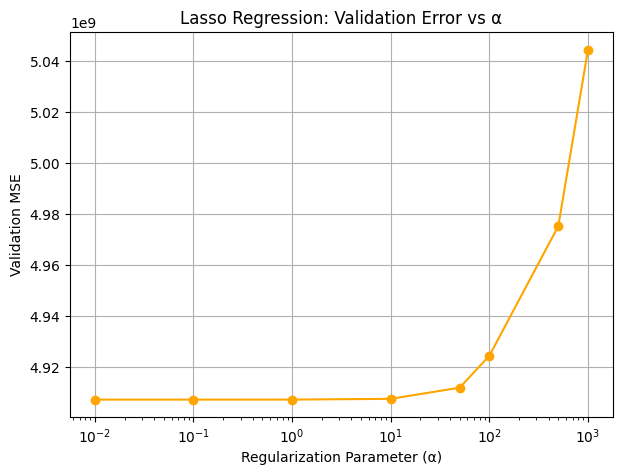

In [199]:

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, lasso_mse, marker='o', color='orange')
plt.xscale('log')
plt.title("Lasso Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()


In [200]:
best_lasso_idx = np.argmin(lasso_mse)
best_lasso_alpha = alphas[best_lasso_idx]
print(f"Best Lasso Alpha: {best_lasso_alpha}")
print(f"Best Lasso Validation MSE: {lasso_mse[best_lasso_idx]:.2f}")
print(f"Best Lasso Validation MAE: {lasso_mae[best_lasso_idx]:.2f}")

Best Lasso Alpha: 0.01
Best Lasso Validation MSE: 4907212147.43
Best Lasso Validation MAE: 50790.07


In [201]:
best_lasso = Lasso(alpha=best_lasso_alpha, max_iter=10000)
best_lasso.fit(X_train_scaled, y_train.ravel())

#Analyzing test set
lasso_test_pred = best_lasso.predict(X_test_scaled)

lasso_test_mse = mean_squared_error(y_test, lasso_test_pred)
lasso_test_mae = mean_absolute_error(y_test, lasso_test_pred)
print(f"Test MSE: {lasso_test_mse:.2f}, MAE: {lasso_test_mae:.2f}")


Test MSE: 4400952078.18, MAE: 48782.04


# Final Comparison and Discussion: Linear vs Ridge vs Lasso Regression

The standard Linear Regression model captured the general trend in the data, though it tended to overfit, especially when the dataset contained noise or correlated features, as it does not include any regularization to control model complexity.

-> Ridge Regression, which applies L2 regularization, improved generalization by penalizing large coefficient values and reducing model variance. It encourages our weighs to be small (shrinks them) but never forces them to zero.As (α) increased, the model’s coefficients were shrunk towards zero, reducing overfitting. However, too large an α led to underfitting, increasing the validation error again.

-> Lasso Regression, using L1 regularization, reduces overfitting and can also perform feature selection by driving some coefficients exactly to zero. This resulted in a simpler, more interpretable model that focused on the most significant predictors. 

Overall linear,lasso,ridge regression all perfomred similarily on this dataset

